<h2 style='color:#27a8ca;text-align:center'> Patch-wise++ Perturbation for Adversarial Targeted Attacks</h2> 
<a href='https://arxiv.org/pdf/2012.15503'> LINK</a>

Patch-wise++ Perturbation (PIM++) is an adversarial attack method designed to generate adversarial examples with **high transferability**, especially for **targeted attacks**. Unlike conventional pixel-wise attacks, PIM++ perturbs **patches** of an image, improving the attack's ability to generalize across different models exceling in targeted attack transferability. It also introduces **temperature scaling** to stabilize gradient updates and prevent underfitting. This notebook provides an overview of the PIM++ attack, its implementation, and the technical insights behind its effectiveness.

---

### **Threat Model**
Adversarial attacks can be categorized based on the attacker's knowledge and intent. PIM++ is designed to operate in the following settings:

- **White-box Attack**: The attacker has full access to the target model’s architecture, parameters, and gradients. This allows precise gradient-based attacks.
- **Black-box Attack**: The attacker has no access to the model's internal parameters and can only query the model for outputs. In this case, the attack relies on **transferability**, i.e., adversarial examples crafted on a substitute model also fool the black-box model.
- **Targeted Attack**: The goal is to mislead the model into classifying an input as a **specific target class** rather than just any incorrect class.

PIM++ is particularly effective in **targeted transfer-based black-box attacks**, where the adversarial example must fool multiple models, including unseen ones.

---



### **PIM++ Implementation**
PIM++ refines adversarial generation through **Average of Ensemble (AoE) ximization**, **patch-wise perturbations**, **amplification mechanisms**, and **temperature scaling**. The adversarial crafting pipeline follows these procedural steps:

![image.png](attachment.png)

1. **Loss Computation**: The adversarial perturbation is guided by the cross-entropy loss between the perturbed input and the desired target class $ y_{adv} $, directing the ximization trajectory.
2. **Gradient Computation**: Backpropagation computes the gradient of the loss function with respect to the input image, identifying the most effective perturbation vectors.
3. **Amplification of Perturbations**: The **amplification factor** $ \beta $ scales the gradient update, enabling the perturbation to escape local xima and optimize adversarial transferability.
4. **Patch-wise Noise Application**: Instead of isolated pixel manipulations, PIM++ perturbs entire **discriminative regions** of the image, enhancing cross-model generalization.
5. **Temperature Scaling**: The logits of the substitute model are adjusted by a **temperature factor** $ \tau $, mitigating overfitting and improving adversarial robustness.
6. **Clipping to $ L_\infty $ Bound**: Perturbations are constrained within an $ \epsilon $-bounded $ L_\infty $-norm to ensure imperceptibility while retaining adversarial efficacy.
7. **Redistribution of Cut Noise**: Any excess perturbation beyond the norm constraint is **reallocated via a project kernel** $ W_p $, preventing adversarial information loss due to clipping.

#### **Mathematical Formulation**
Given a model $ f $ with parameters $ \theta $, an input $ x $, and a target label $ y_{adv} $, the adversarial perturbation is computed as:

$$
x_{adv}^{t+1} = \text{Clip}_{x, \epsilon} \{ x_{adv}^{t} - \beta \cdot \frac{\epsilon}{T} \cdot \text{sign}(\nabla_x J(x_{adv}^{t}, y_{adv})) - \gamma \cdot \text{sign}(W_p * C) \}
$$

where:
- $ \beta $ = **amplification factor**
- $ \tau $ = **temperature for scaling logits**
- $ C $ = **cut noise (excess perturbation beyond allowed bound)**
- $ W_p $ = **project kernel for noise redistribution**
- $ \text{Clip}_{x, \epsilon} $ ensures perturbations stay within $ L_\infty $ bounds

---

### **Key Components**

#### **1. Patch-wise Perturbations**
Unlike pixel-wise attacks, PIM++ perturbs entire **patches** of an image. This improves attack transferability by ensuring that perturbations affect **regions** rather than individual pixels, increasing the likelihood of success across different models.

#### **2. Amplification Factor ($ \beta $)**
The amplification factor controls how much the gradient is scaled in each iteration. Without it, adversarial examples can get stuck in **local minima**, reducing effectiveness. However, in targeted attacks, excessive amplification can cause **underfitting**, which PIM++ mitigates with **temperature scaling**.
- **Increasing $ \beta $ (Amplification Factor)**: Allows faster perturbation updates, escaping local minima more efficiently but can lead to underfitting if too high.

#### **3. Temperature Scaling ($ \tau $)**
A softmax **temperature parameter** is applied to logits before computing gradients:
$$
l'(x) = \frac{l(x)}{\tau}
$$
- **Higher temperatures ($ \tau > 1 $)** distribute probability mass more evenly, avoiding local optima.
- Helps **stabilize** adversarial training and increase transferability.
- **Increasing $ \tau $ (Temperature Scaling Factor)**: Smoothens class probability distributions, enhancing black-box transferability but may weaken the attack in white-box scenarios.

#### **4. Cut Noise ($ C $) & Project Kernel ($ W_p $)**
When the cumulative perturbation **exceeds** the allowed $ L_\infty $-norm bound **$ \epsilon $**, the excess is **not discarded** but instead **redistributed** smartly to surrounding pixels using a kernel $ W_p $ of size $k_w$. This prevents loss of adversarial effect and ensures the attack remains effective.

The project kernel is defined as:
$$
W_p[i, j] =
\begin{cases}  
0, & \text{if } i = \lfloor k_w/2 \rfloor, j = \lfloor k_w/2 \rfloor \\  
1 / (k_w^2 - 1), & \text{otherwise}
\end{cases}
$$
where $ k_w $ is the **kernel size** (optimal value = 3).
- **Increasing $ k_w $ (Kernel Size)**: Leads to a broader spread of perturbation, enhancing generalization but possibly reducing attack strength on individual models.
---

#### **How Redistribution Enhances Attack Transferability**
Unlike traditional adversarial attacks where excess perturbations are clipped and lost, PIM++ ensures that every perturbation contributes to the adversarial effect. By redistributing excess perturbation intelligently, the attack remains potent without exceeding the defined perturbation budget. The kernel $ W_p $ acts as a **spatial smoothing mechanism**, ensuring that perturbations do not concentrate on specific pixels but are dispersed across larger regions, enhancing the likelihood of fooling diverse models.

#### **Patch-wise Perturbation Calculation**
In PIM++, the perturbation is computed in **localized patches** rather than individual pixels. Each patch is treated as a **fundamental adversarial unit**, ensuring that noise is applied in a manner that mimics natural image variations. This enhances both **perceptual stealth** and **transferability** across models. The redistribution kernel $ W_p $ governs how perturbations flow within and between patches, ensuring that no information is wasted during the perturbation process.

#### **Differences from Traditional Clipping Methods**
- **Conventional Clipping**: Any perturbation exceeding $ \epsilon $ is discarded, reducing the overall effectiveness of the attack.
- **PIM++ Redistribution**: Instead of discarding, the excess perturbation is **spread across nearby patches**, maintaining adversarial effectiveness while adhering to $ L_\infty $ constraints.
- **Impact**: This method ensures that **every perturbation step contributes to misclassification**, preventing adversarial information loss.

---

### Experiments and Results

#### **1. Evaluation Metrics**
- 1. **Success Rate Definition**

   - Targeted Attack Success Rate
The success rate is defined as the proportion of adversarial examples that are misclassified by the model as the target label (the label the attacker wants the model to predict) rather than the ground truth label (the correct label for the input).

Mathematically, for a given set of adversarial examples $ X_{adv} $ and a target label $ y_{adv} $, the success rate is calculated as:

$$
\text{Success Rate} = \frac{\text{Number of adversarial examples classified as } y_{adv}}{\text{Total number of adversarial examples}} \times 100\%
$$

   - Non-Targeted Attack Success Rate
In non-targeted attacks, the success rate is the proportion of adversarial examples that are misclassified as any label other than the ground truth label.

- 2. **Average of Ensemble (AoE)**

   - The AoE metric evaluates the performance of adversarial examples across multiple models. It calculates the average success rate of adversarial examples crafted using an ensemble of models, providing a more comprehensive measure of attack transferability.
   - Specifically, AoE averages the performance across all white-box models:

$$
\text{AoE} = \frac{1}{K} \sum_{k=1}^{K} S(f_k(X_{adv}), Y_{adv})
$$

Where:
- $ X_{adv} $ and $ Y_{adv} $ denote the set of all resultant adversarial examples and their corresponding target labels.
- $ f_k(\cdot) $ represents the output label of the $ k $-th model.
- $ S(\cdot, \cdot) $ calculates the targeted success rate.

With this evaluation metric, we can better measure whether the adversarial examples are in the global optimum (i.e., a high attack success rate of AoE) rather than the local optimum of the ensemble models (i.e., a high attack success rate of ensemble models but a low attack success rate of AoE).
However, we did not apply the AoE metric to assess the success rate of the targeted attack because our focus is solely on the success rate of the target model, rather than comparing the success rates of different adversarial attacks.


#### **2. Experimental Setup**

- **Datasets**: <a href='https://github.com/qilong-zhang/Targeted_Patch-wise-plusplus_iterative_attack/tree/main/dataset'> 1000 ImageNet samples </a>
- **Models**: ResNet-50, ResNet-101, ResNet-152 DenseNet-121, VGG-16, VGG-19,Inception-v3 and ResNeXt-50.

#### **3. Results**

- **Effect of Amplification Factor ($ \beta $) [Untargeted]**

| Model Name     | Non-Targeted Attack Success Rate ($\beta$ = 5) | Non-Targeted Attack Success Rate ($\beta$ = 10) |
|----------------|-----------------------------------------------|------------------------------------------------|
| Inception V3   | 100%                                          | 100%                                           |
| ResNet152      | 47.9%                                         | 50.4%                                          |
| ResNet101      | 53%                                           | 54.4%                                          |
| ResNet50       | 57.6%                                         | 61.8%                                          |
| VGG16          | 71.4%                                         | 73.9%                                          |
| VGG19          | 71.6%                                         | 74.5%                                          |
| DenseNet       | 51.2%                                         | 56.70%                                         |
| ResNeXt        | 56.8%                                         | 56.8%                                          |


- **Evaluation on Untargeted & Targeted Attacks**

| Model Name | Untargeted Attack Success Rate | Non-Targeted Success Rate | Targeted Success Rate (10 iter.) | Targeted Success Rate (20 iter.) |
|------------|-------------------------------|--------------------------|--------------------------------|--------------------------------|
| **Inception V3** | 100% | 99.9% | 80.8% | 95.70% |
| **ResNet152** | 100% | 100% | 85.7% | 95.20% |
| **ResNet101** | 100% | 100% | 87.7% | 96.60% |
| **ResNet50** | 100% | 100% | 88.9% | 97.00% |
| **VGG16** | 100% | 100% | 78.3% | 87.80% |
| **VGG19** | 100% | 100% | 75.3% | 87.50% |
| **DenseNet** | 98.1% | 93.7% | 33.1% | 47.20% |
| **ResNeXt** | 99.4% | 97.6% | 35.8% | 51.80% |


**Note:**  
To verify the actual transferability as proposed in the paper, we also tested the adversarial examples on several additional models that were not originally considered in the evaluation of the paper. This includes **ResNeXt**, **VGG16**, and **VGG19**, in order to further assess their performance and transferability across different model architectures.

---
### **Why PIM++ Works: A Technical Perspective**

1. **Patch-wise Perturbations Enhance Transferability**
   - Instead of single-pixel changes, perturbations are distributed across **discriminative regions** of the model.
   - Different models focus on different features; patch-wise noise ensures coverage across architectures.

2. **Amplification Factor Escapes Local Minima**
   - Scaling the gradient by $ \beta $ prevents the perturbation from getting stuck.
   - Improves adversarial success rates in black-box models.

3. **Temperature Scaling Prevents Overfitting**
   - Reduces the problem of the attack overfitting to the substitute model.
   - Ensures adversarial examples are **generalizable** across multiple models.

4. **Redistribution of Excess Noise Prevents Clipping Effects**
   - Instead of discarding clipped noise, PIM++ reassigns it to neighboring pixels.
   - This avoids losing critical adversarial information.

---
<!-- 
### **Comparison with Other Attacks**
| Attack Type | Perturbation Method | Transferability | Computational Cost |
|------------|--------------------|----------------|------------------|
| FGSM | Single-step gradient sign | Low | Low |
| I-FGSM | Iterative FGSM | Medium | Medium |
| MI-FGSM | Momentum-based FGSM | Medium-High | Medium |
| DI-FGSM | Input transformation-based FGSM | High | Medium-High |
| PIM++ (Ours) | Patch-wise + Amplification + Temperature Scaling | **Very High** | **High** |

--- -->
<!-- 
### **Conclusion**
PIM++ significantly improves targeted adversarial attack **transferability**, particularly in black-box settings. By combining **patch-wise perturbations**, **amplified gradients**, and **temperature scaling**, it outperforms existing methods while maintaining high attack success rates in **both white-box and black-box models**. Extensive experiments show **up to 33.1% improvement** over state-of-the-art black-box targeted attacks. -->


### **Code Implementation**

In [9]:
import os
import torch
import torchvision.models as models
from torch.autograd import Variable as V
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import warnings
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import argparse
import matplotlib.pyplot as plt
from torch.utils import data

torch.manual_seed(0)
np.random.seed(0)



In [ ]:
class Normalize(nn.Module):

    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, input):
        size = input.size()
        x = input.clone()
        for i in range(size[1]):
            x[:, i] = (x[:, i] - self.mean[i]) / self.std[i]
        return x


class Permute(nn.Module):
    def __init__(self, permutation=[2, 1, 0]):
        super().__init__()
        self.permutation = permutation

    def forward(self, input):
        return input[:, self.permutation]
    


class ImageNet(data.Dataset):
    def __init__(self, dir, csv_path, transforms = None):
        self.dir = dir   
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        TargetClass = img_obj['TargetClass'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, ImageID, Truelabel, TargetClass

    def __len__(self):
        return len(self.csv)

In [ ]:
torch.backends.cudnn.benchmark = True

input_csv = '../submission/dev_dataset.csv'
input_dir = '..submission/dataset'

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
max_epsilon = 16.0
num_iter_set = 10
image_width = 299
image_height = 299
image_resize = 330
batch_size = 10
momentum = 1.0
amplification = 10.0
prob = 0.7
tau = 1.25

transforms = T.Compose([T.CenterCrop(image_width), T.ToTensor()])

def project_kern(kern_size):
    kern = np.ones((kern_size, kern_size), dtype=np.float32) / (kern_size ** 2 - 1)
    kern[kern_size // 2, kern_size // 2] = 0.0
    kern = kern.astype(np.float32)
    stack_kern = np.stack([kern, kern, kern])
    stack_kern = np.expand_dims(stack_kern, 1)
    stack_kern = torch.tensor(stack_kern).cuda()
    return stack_kern, kern_size // 2

def project_noise(x, stack_kern, padding_size):
    x = F.conv2d(x, stack_kern, padding=(padding_size, padding_size), groups=3)
    return x

stack_kern, padding_size = project_kern(3)

def clip_by_tensor(t, t_min, t_max):
    result = (t >= t_min).float() * t + (t < t_min).float() * t_min
    result = (result <= t_max).float() * result + (result > t_max).float() * t_max
    return result

def graph(x, gt, tgc, x_min, x_max):
    eps = max_epsilon / 255.0
    num_iter = num_iter_set
    alpha = eps / num_iter
    alpha_beta = alpha * amplification
    gamma = alpha_beta

    inc_v3 = torch.nn.Sequential(Normalize(mean, std),
                                models.inception_v3(pretrained=True).eval().cuda())
    vgg16 = torch.nn.Sequential(Normalize(mean, std),
                                 models.vgg16(pretrained=True).eval().cuda())
    vgg19 = torch.nn.Sequential(Normalize(mean, std),
                                 models.vgg19(pretrained=True).eval().cuda())
    res101 = torch.nn.Sequential(Normalize(mean, std),
                                 models.resnet101(pretrained=True).eval().cuda())
    res50 = torch.nn.Sequential(Normalize(mean, std),
                                 models.resnet50(pretrained=True).eval().cuda())
    res152 = torch.nn.Sequential(Normalize(mean, std),
                                 models.resnet152(pretrained=True).eval().cuda())
    x.requires_grad = True
    amplification = 0.0
    for i in range(num_iter):
        x.grad = None
        output_v3 = inc_v3(x)
        output_vgg16 = vgg16(x)
        output_vgg19 = vgg19(x)
        output_res50 = res50(x)
        output_res152 = res152(x)
        output_res101 = res101(x)

        avg_logits = (output_v3 + output_res50 + output_res101 + output_res152 + output_vgg16 + output_vgg19) / (6 * tau)
        loss = -F.cross_entropy(avg_logits, gt) + F.cross_entropy(avg_logits, tgc)
        loss.backward()
        noise = x.grad.data

        amplification += alpha_beta * torch.sign(noise)
        cut_noise = torch.clamp(abs(amplification) - eps, 0, 10000.0) * torch.sign(amplification)
        projection = gamma * torch.sign(project_noise(cut_noise, stack_kern, padding_size))

        x = x - alpha_beta * torch.sign(noise) - projection
        x = clip_by_tensor(x, x_min, x_max)
        x = V(x, requires_grad=True)

    return x.detach()

def input_diversity(input_tensor):
    rnd = torch.randint(image_width, image_resize, ())
    rescaled = F.interpolate(input_tensor, size=[rnd, rnd], mode='bilinear', align_corners=True)
    h_rem = image_resize - rnd
    w_rem = image_resize - rnd
    pad_top = torch.randint(0, h_rem, ())
    pad_bottom = h_rem - pad_top
    pad_left = torch.randint(0, w_rem, ())
    pad_right = w_rem - pad_left
    pad_list = (pad_left, pad_right, pad_top, pad_bottom)
    padded = nn.ConstantPad2d((pad_left, pad_right, pad_top, pad_bottom), 0.)(rescaled)
    padded = nn.functional.interpolate(padded, [image_resize, image_resize])
    return padded if torch.rand(()) < prob else input_tensor

def main():
    vgg16 = torch.nn.Sequential(Normalize(mean, std),
                                 models.vgg16(pretrained=True).eval().cuda())
    vgg19 = torch.nn.Sequential(Normalize(mean, std),
                                 models.vgg19(pretrained=True).eval().cuda())
    res101 = torch.nn.Sequential(Normalize(mean, std),
                                 models.resnet101(pretrained=True).eval().cuda())
    res50 = torch.nn.Sequential(Normalize(mean, std),
                                 models.resnet50(pretrained=True).eval().cuda())
    res152 = torch.nn.Sequential(Normalize(mean, std),
                                 models.resnet152(pretrained=True).eval().cuda())
    inc_v3 = torch.nn.Sequential(Normalize(mean, std),
                                 models.inception_v3(pretrained=True).eval().cuda())
    resnext50_32x4d = torch.nn.Sequential(Normalize(mean, std),
                                          models.resnext50_32x4d(pretrained=True).eval().cuda())
    dense161 = torch.nn.Sequential(Normalize(mean, std),
                                   models.densenet169(pretrained=True).eval().cuda())

    X = ImageNet(input_dir, input_csv, transforms)
    data_loader = DataLoader(X, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)
    sum_res152, sum_res101, sum_res50, sum_vgg16, sum_vgg19, sum_v3, sum_rext, sum_den = 0, 0, 0, 0, 0, 0, 0, 0
    df = pd.read_csv(input_csv)
    for images, image_id, gt_cpu, tgc in tqdm(data_loader):
        gt = gt_cpu.cuda()
        tgc = tgc.cuda()
        images = images.cuda()
        images_min = clip_by_tensor(images - max_epsilon / 255.0, 0.0, 1.0)
        images_max = clip_by_tensor(images + max_epsilon / 255.0, 0.0, 1.0)
        adv_img = graph(images, gt, tgc, images_min, images_max)
        for i in range(adv_img.shape[0]):
            img = adv_img[i].cpu().numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)
            img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)
            img.save(f'dataset/adv_img/{image_id[i]}')

        with torch.no_grad():
            sum_res152 += (res152(adv_img).argmax(1) == tgc).detach().sum().cpu()
            sum_v3 += (inc_v3(adv_img).argmax(1) == tgc).detach().sum().cpu()
            sum_rext += (resnext50_32x4d(adv_img).argmax(1) == tgc).detach().sum().cpu()
            sum_den += (dense161(adv_img).argmax(1) == tgc).detach().sum().cpu()
            sum_res50 += (res50(adv_img).argmax(1) == tgc).detach().sum().cpu()
            sum_res101 += (res101(adv_img).argmax(1) == tgc).detach().sum().cpu()
            sum_vgg16 += (vgg16(adv_img).argmax(1) == tgc).detach().sum().cpu()
            sum_vgg19 += (vgg19(adv_img).argmax(1) == tgc).detach().sum().cpu()

    print('inc_v3 = {:.2%}'.format(sum_v3 / 1000.0))
    print('res152 = {:.2%}'.format(sum_res152 / 1000.0))
    print('res101 = {:.2%}'.format(sum_res101 / 1000.0))
    print('res50 = {:.2%}'.format(sum_res50 / 1000.0))
    print('vgg16 = {:.2%}'.format(sum_vgg16 / 1000.0))
    print('vgg19 = {:.2%}'.format(sum_vgg19 / 1000.0))
    print('dense = {:.2%}'.format(sum_den / 1000.0))
    print('rext = {:.2%}'.format(sum_rext / 1000.0))

if __name__ == '__main__':
    main()


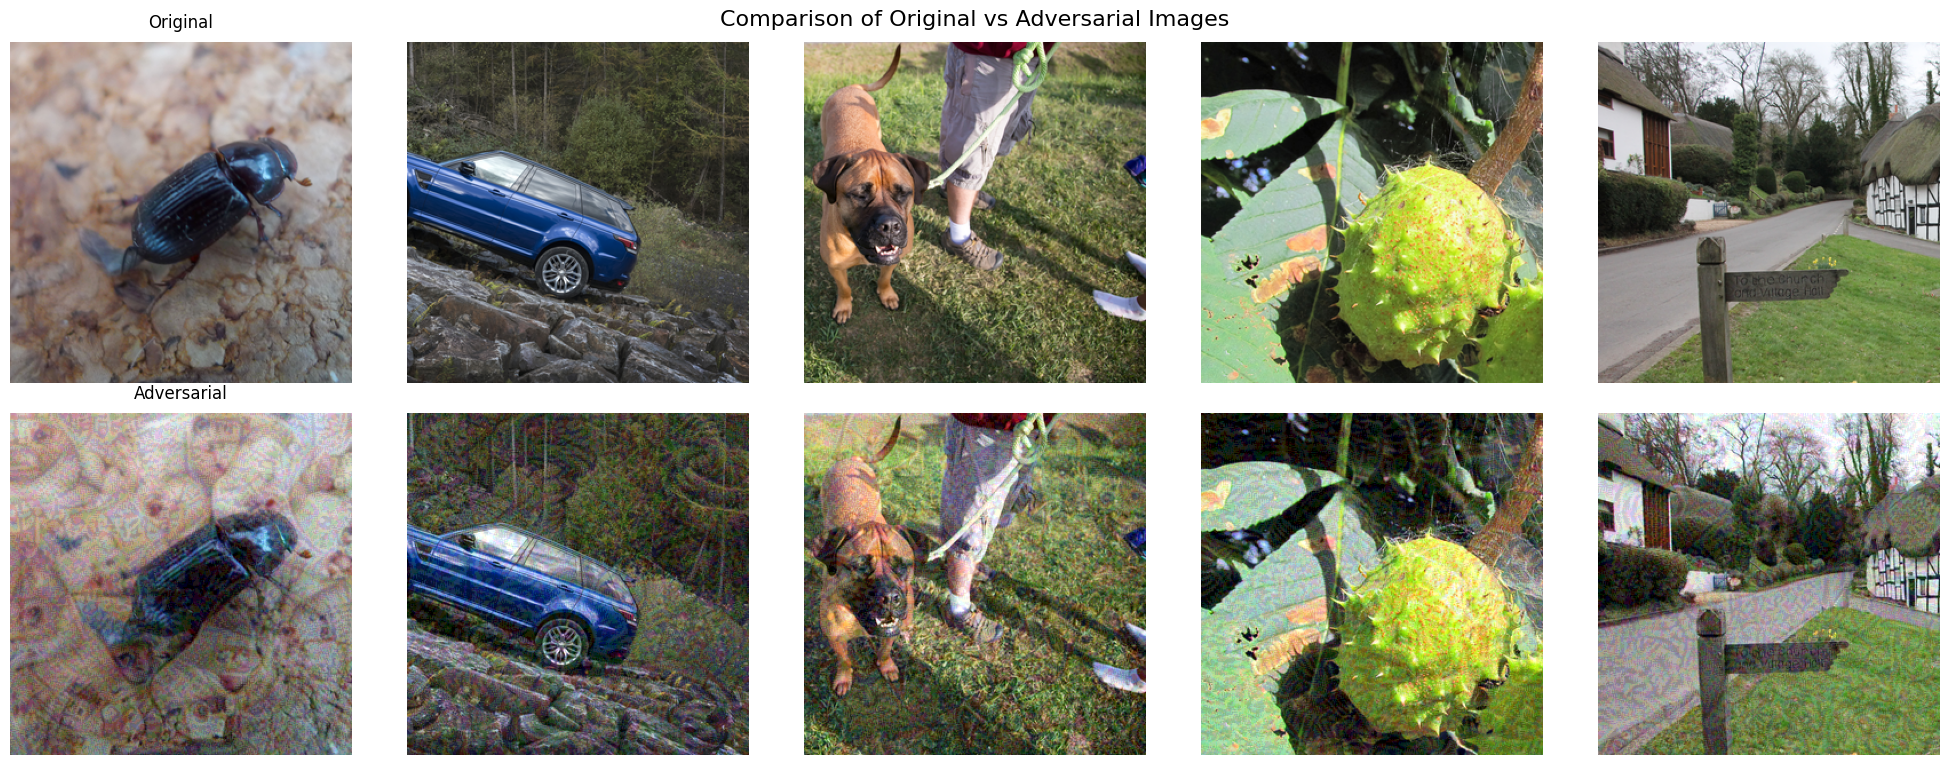

In [ ]:
adv_dir = '../submission/adversarial_images'
orig_dir = '../submission/original_images'

adv_images = sorted([f for f in os.listdir(adv_dir) if f.endswith('.png')])

n_images = len(adv_images)
fig = plt.figure(figsize=(20, 8))
rows, cols = 2, min(5, n_images)

for idx, img_name in enumerate(adv_images[:cols]):
    orig_path = os.path.join(orig_dir, img_name)
    orig_img = Image.open(orig_path)
    
    adv_path = os.path.join(adv_dir, img_name)
    adv_img = Image.open(adv_path)
    
    ax1 = plt.subplot(2, cols, idx + 1)
    plt.imshow(orig_img)
    plt.axis('off')
    if idx == 0:
        plt.title('Original', pad=10)
    
    ax2 = plt.subplot(2, cols, idx + 1 + cols)
    plt.imshow(adv_img)
    plt.axis('off')
    if idx == 0:
        plt.title('Adversarial', pad=10)

plt.suptitle('Comparison of Original vs Adversarial Images', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()